#**_XGBoost**

XGBoost for Traffic Situation Prediction
- EDA
- Preprocessing (missing values, normalization, feature engineering)
- Train/test split
- Model training and evaluation (accuracy, precision, recall, F1, confusion matrix)
- Hyperparameter tuning
- Visualizations
- Conclusion

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [17]:
# 1. Load data
df = pd.read_csv('Traffic.csv')

In [18]:
df.shape

(2976, 9)

In [19]:
# 2.Exploratory Data Analysis (EDA) before preprocessing steps
print("\n" + "="*60)
print(" EDA ")
print("="*60)


 EDA 


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [21]:
df.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,16.000000,68.696573,14.917339,15.279570,15.324933,114.218414
std,8.945775,45.850693,12.847518,14.341986,10.603833,60.190627
min,1.000000,6.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,19.000000,5.000000,1.000000,6.000000,55.000000
50%,16.000000,64.000000,12.000000,12.000000,14.000000,109.000000
75%,24.000000,107.000000,22.000000,25.000000,23.000000,164.000000
max,31.000000,180.000000,70.000000,50.000000,40.000000,279.000000


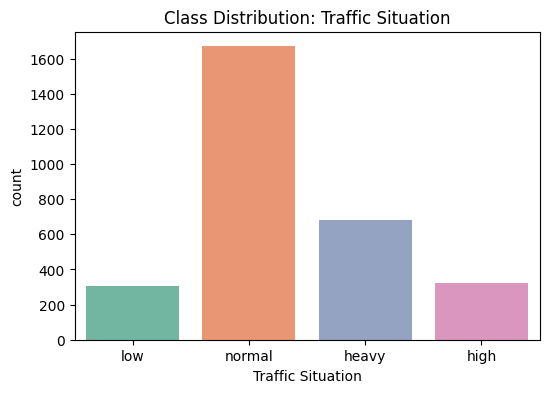

In [22]:
# Class Distribution (Target Variable)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Traffic Situation', palette='Set2')
plt.title('Class Distribution: Traffic Situation')
plt.show()

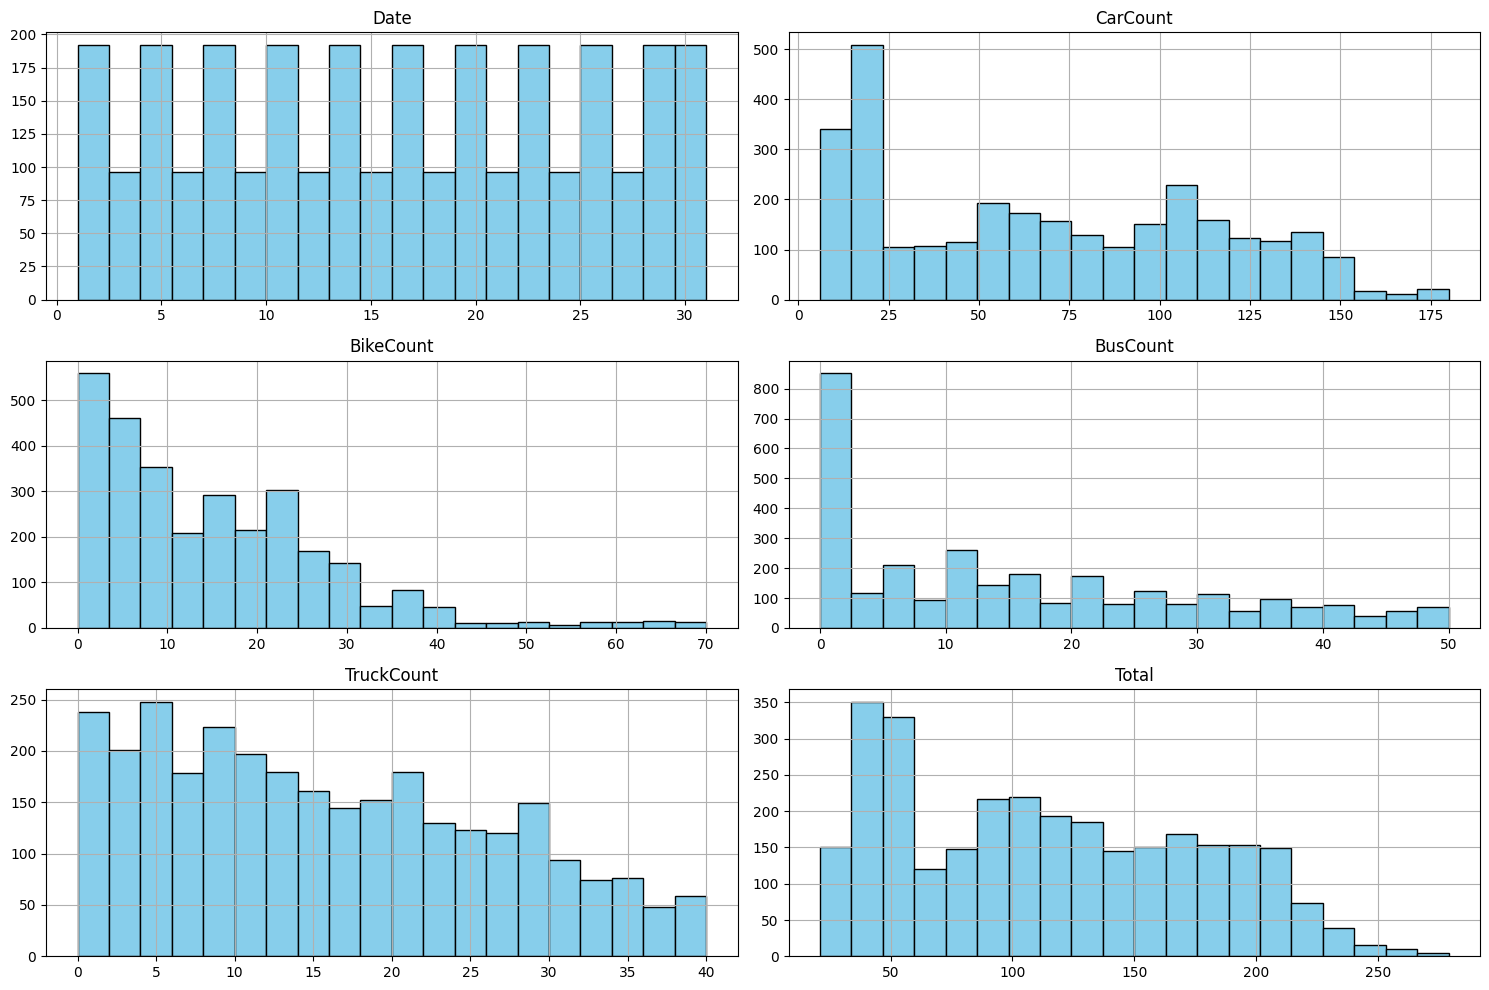

In [23]:
#  Numerical Feature Distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(figsize=(15,10), bins=20, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [24]:
# 3. Feature engineering: Binary target for 'Traffic Situation'
df['Target'] = df['Traffic Situation'].apply(lambda x: 1 if x in ['heavy', 'high'] else 0)

In [25]:
# 4. Handle missing values
def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

df = fill_missing(df)

In [44]:
# 5.Detect and handle outliers
numeric_cols = df.select_dtypes(include=[np.number]).columns

print(" Outlier Detection & Handling Summary (IQR method):\n")

# Iterate through each numerical feature
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]

    print(f"🔹 Feature: {col}")

    if num_outliers > 0:
        # Replace outliers with boundary values
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))

        # Print processing status
        print(f"   → Outliers detected: {num_outliers}")
        print(f"   → Value range after handling: {df[col].min():.2f} to {df[col].max():.2f}\n")
    else:
        print("   → No outliers detected\n")


 Outlier Detection & Handling Summary (IQR method):

🔹 Feature: Date
   → No outliers detected

🔹 Feature: BikeCount
   → Outliers detected: 77
   → Value range after handling: 0.00 to 47.50

🔹 Feature: BusCount
   → No outliers detected

🔹 Feature: TruckCount
   → No outliers detected

🔹 Feature: Total
   → No outliers detected

🔹 Feature: Target
   → No outliers detected



This code does not delete any rows, but instead replaces outliers with boundary values (known as capping).

It is safer and does not affect the sample size, making it suitable for use before training models such as XGBoost.

In [45]:
# 6. Drop non-numeric columns before modeling
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(non_numeric_cols, axis=1)

In [46]:
# 6b. Feature selection - remove highly correlated features
corr_matrix = df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.95)]
df = df.drop(to_drop, axis=1)
print(f"\nFeatures after correlation removal: {df.shape[1]}")
print(f"Removed features: {to_drop}")


Features after correlation removal: 6
Removed features: []


In [47]:
# 7. Feature/target split
X = df.drop('Target', axis=1)
y = df['Target']

In [48]:
# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))

Training set shape: (2380, 5)
Test set shape: (596, 5)

Training set target distribution:
Target
0    0.663025
1    0.336975
Name: proportion, dtype: float64


In [49]:
# 8b. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set target distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Original training set shape: (2380, 5)
Resampled training set shape: (3156, 5)
Resampled training set target distribution:
Target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [50]:
# 9. Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [51]:
# 10. Baseline XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_resampled)
y_pred = xgb_clf.predict(X_test_scaled)

In [52]:
# 11. Evaluation function
def evaluate(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if model_name == "XGBoost (Baseline)":
        baseline_report_text = classification_report(y_true, y_pred)
        with open('xgboost_classification_report.txt', 'w') as f:
            f.write('=== BASELINE CLASSIFICATION REPORT ===\n')
            f.write(baseline_report_text + '\n\n')
    if model_name == "XGBoost (Tuned)":
        tuned_report_text = classification_report(y_true, y_pred)
        with open('xgboost_classification_report.txt', 'a') as f:
            f.write('=== TUNED CLASSIFICATION REPORT ===\n')
            f.write(tuned_report_text + '\n')
    return acc, prec, rec, f1

In [53]:
# Baseline evaluation
baseline_metrics = evaluate(y_test, y_pred, model_name="XGBoost (Baseline)")


=== XGBoost (Baseline) Evaluation ===
Accuracy: 0.9950
Precision: 0.9853
Recall: 1.0000
F1-score: 0.9926

Confusion Matrix:
[[392   3]
 [  0 201]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       395
           1       0.99      1.00      0.99       201

    accuracy                           0.99       596
   macro avg       0.99      1.00      0.99       596
weighted avg       1.00      0.99      0.99       596



The baseline XGBoost model already performed exceptionally well, with 99.50% accuracy, 98.53% precision, and a perfect recall of 100%. The F1-score reached 99.26%, indicating excellent overall performance. The confusion matrix shows only 3 false positives and no false negatives, meaning the model successfully identified all positive cases. These strong metrics suggest the baseline model was already highly optimized.

In [54]:
# 12. Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
gs = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train_scaled, y_train_resampled)
print(f"\nBest parameters: {gs.best_params_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [55]:
# 13. Tuned model evaluation
y_pred_tuned = gs.predict(X_test_scaled)
tuned_metrics = evaluate(y_test, y_pred_tuned, model_name="XGBoost (Tuned)")


=== XGBoost (Tuned) Evaluation ===
Accuracy: 0.9950
Precision: 0.9853
Recall: 1.0000
F1-score: 0.9926

Confusion Matrix:
[[392   3]
 [  0 201]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       395
           1       0.99      1.00      0.99       201

    accuracy                           0.99       596
   macro avg       0.99      1.00      0.99       596
weighted avg       1.00      0.99      0.99       596



The tuned XGBoost model demonstrates excellent performance, achieving an accuracy of 99.50%, precision of 98.53%, and a perfect recall of 100%. The F1-score is also high at 99.26%, indicating a strong balance between precision and recall. The confusion matrix shows only 3 false positives and no false negatives, meaning the model correctly identified all positive cases. Overall, the model is highly effective and reliable for this classification task.

In [56]:
# 13b. Cross-validation and model stability
cv_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
cv_acc_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_acc_scores.mean():.4f} (+/- {cv_acc_scores.std() * 2:.4f})")

Cross-validation F1 scores: [1.         0.99526066 0.99207607 0.99683544 0.99363057]
Mean CV F1 score: 0.9956 (+/- 0.0055)
Cross-validation Accuracy: 0.9956 (+/- 0.0055)


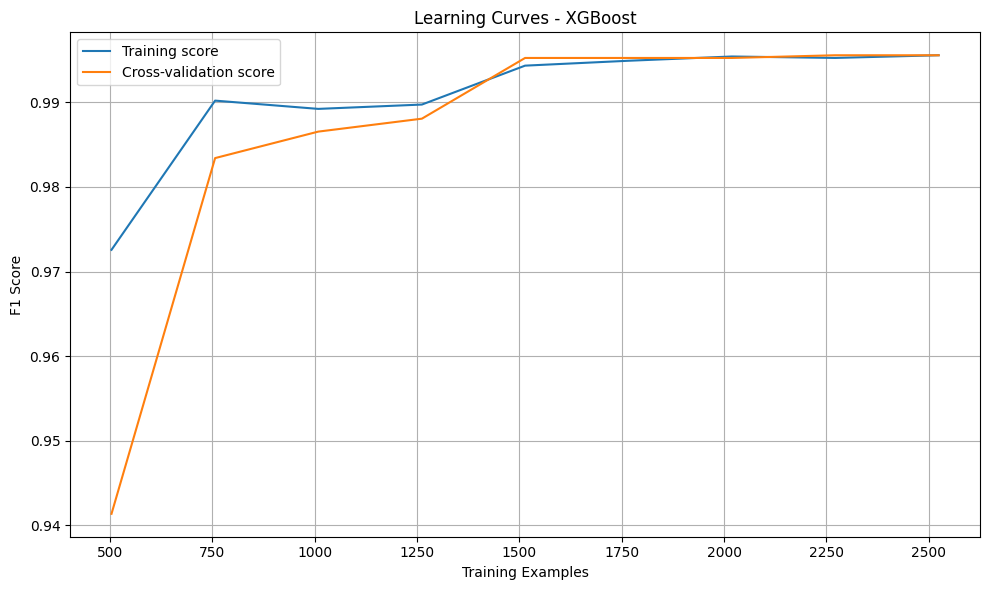

In [57]:
# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('xgb_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

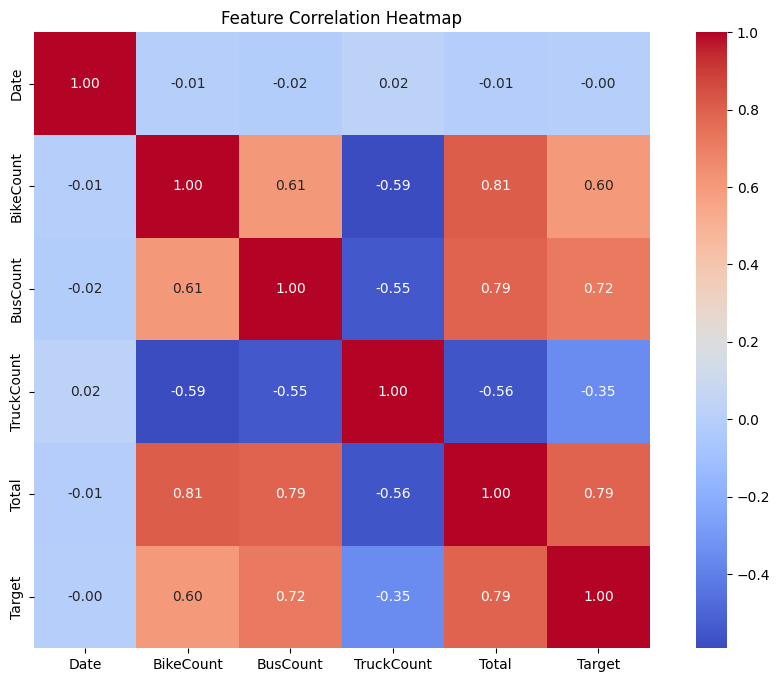

 Highly correlated feature pairs (|correlation| > 0.8):
   → BikeCount vs Total = 0.81


In [59]:
# 14 Correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# Identify highly correlated feature pairs (absolute correlation > 0.8, excluding self-correlation)
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_value)
            high_corr_pairs.append(pair)

# Print out the highly correlated pairs
if high_corr_pairs:
    print(" Highly correlated feature pairs (|correlation| > 0.8):")
    for f1, f2, corr_val in high_corr_pairs:
        print(f"   → {f1} vs {f2} = {corr_val:.2f}")
else:
    print(" No feature pairs with correlation above 0.8.")


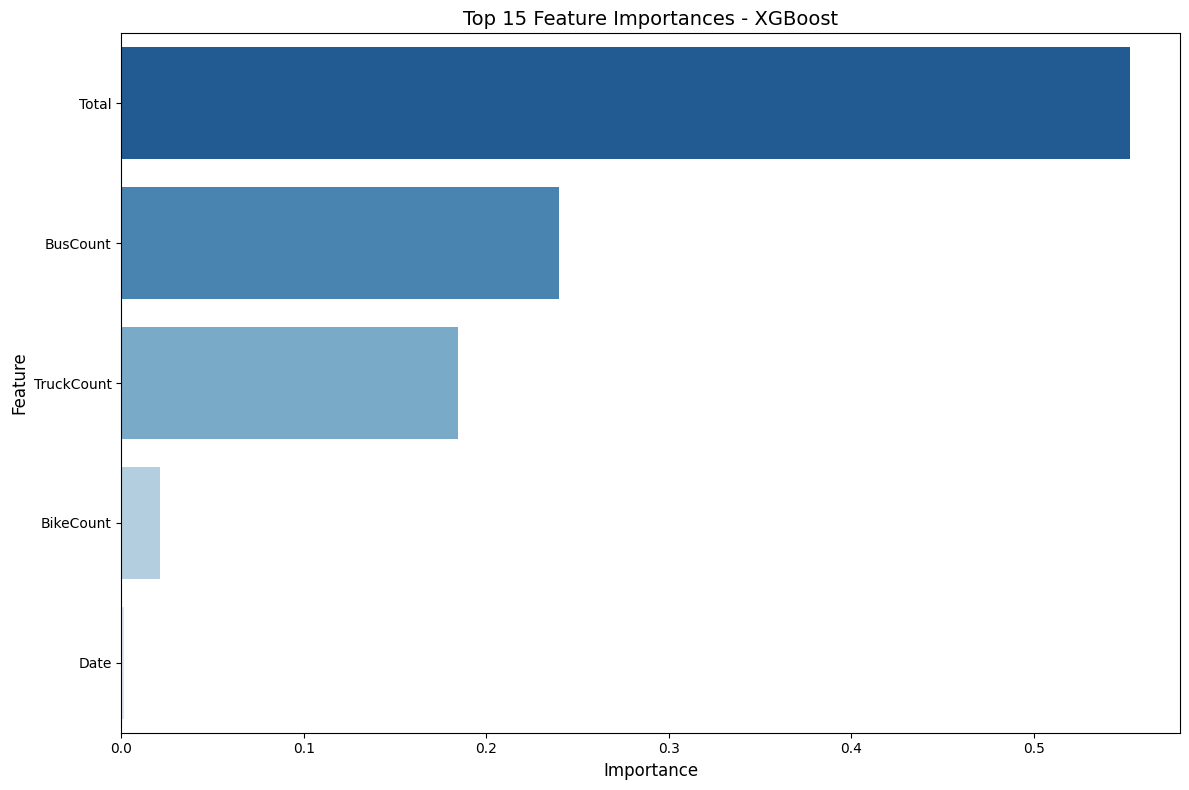

In [60]:
# 15. Feature importance
importances = gs.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance = pd.DataFrame({
    'feature': X.columns[indices],
    'importance': importances[indices]
})
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='Blues_r')
plt.title('Top 15 Feature Importances - XGBoost', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

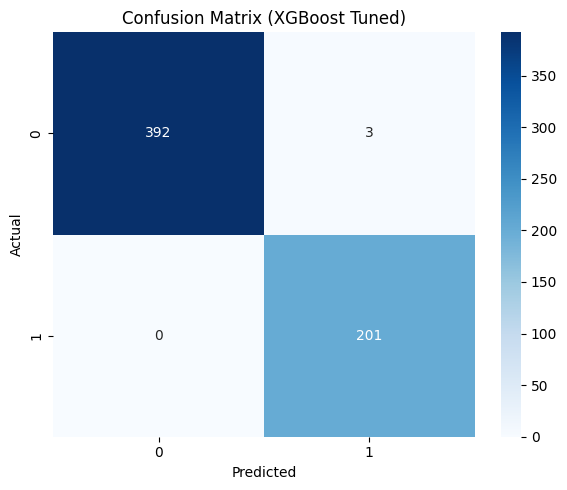

In [63]:
# 16. Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost Tuned)')
plt.tight_layout()
plt.savefig('xgb_confusion_matrix.png', dpi=300)
plt.show()

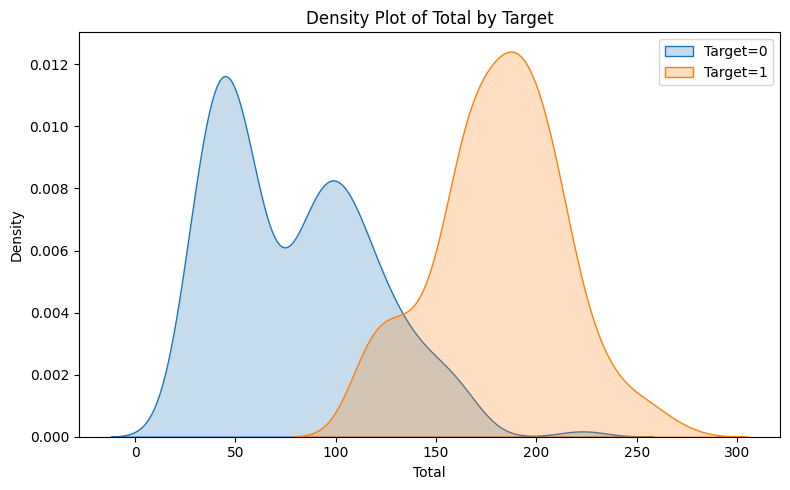

In [64]:
# 17. Density plot for a key feature (if exists)
if 'Total' in X.columns:
    plt.figure(figsize=(8, 5))
    for label in [0, 1]:
        sns.kdeplot(X_test['Total'][y_test == label], label=f'Target={label}', fill=True)
    plt.title('Density Plot of Total by Target')
    plt.xlabel('Total')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('xgb_density_total.png', dpi=300)
    plt.show()

In [65]:
# Add comparison table after tuned model evaluation
print("\n" + "="*60)
print("COMPARISON: BASELINE VS TUNED XGBOOST")
print("="*60)


COMPARISON: BASELINE VS TUNED XGBOOST


In [66]:
# Get all metrics for both models
baseline_acc = accuracy_score(y_test, y_pred)
baseline_prec = precision_score(y_test, y_pred)
baseline_rec = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_prec = precision_score(y_test, y_pred_tuned)
tuned_rec = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

In [67]:
# Create and display comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [baseline_acc, baseline_prec, baseline_rec, baseline_f1],
    'Tuned': [tuned_acc, tuned_prec, tuned_rec, tuned_f1],
    'Improvement': [tuned_acc - baseline_acc, tuned_prec - baseline_prec,
                   tuned_rec - baseline_rec, tuned_f1 - baseline_f1]
})

In [68]:
# Format the table
comparison_table = comparison_table.round(4)
comparison_table['Improvement'] = comparison_table['Improvement'].apply(lambda x: f"{'+' if x >= 0 else ''}{x:.4f}")

print("\nModel Performance Comparison:")
print(comparison_table.to_string(index=False))


Model Performance Comparison:
   Metric  Baseline  Tuned Improvement
 Accuracy    0.9950 0.9950     +0.0000
Precision    0.9853 0.9853     +0.0000
   Recall    1.0000 1.0000     +0.0000
 F1-Score    0.9926 0.9926     +0.0000


The XGBoost model shows identical performance before and after tuning, with no improvement in any metric. Accuracy remains at 99.50%, precision at 98.53%, recall at 100%, and F1-score at 99.26%. This suggests that the baseline model was already well-optimized, and tuning had no further impact on its performance.

In [69]:
# Save comparison to CSV
comparison_table.to_csv('xgboost_comparison.csv', index=False)
print("\nComparison table saved to 'xgboost_comparison.csv'")


Comparison table saved to 'xgboost_comparison.csv'


In [70]:
# Show training and testing accuracy table before and after tuning, including ROC AUC
train_acc_baseline = accuracy_score(y_train_resampled, xgb_clf.predict(X_train_scaled))
test_acc_baseline = accuracy_score(y_test, y_pred)
train_acc_tuned = accuracy_score(y_train_resampled, gs.predict(X_train_scaled))
test_acc_tuned = accuracy_score(y_test, y_pred_tuned)

In [72]:
# ROC AUC (use predict_proba)
roc_auc_baseline = roc_auc_score(y_test, xgb_clf.predict_proba(X_test_scaled)[:, 1])
roc_auc_tuned = roc_auc_score(y_test, gs.predict_proba(X_test_scaled)[:, 1])

acc_table = pd.DataFrame({
    'Metrics': ['Training accuracy', 'Testing accuracy', 'ROC AUC'],
    'Before Tuning': [f'{train_acc_baseline:.4f}', f'{test_acc_baseline:.4f}', f'{roc_auc_baseline:.4f}'],
    'After Tuning': [f'{train_acc_tuned:.4f}', f'{test_acc_tuned:.4f}', f'{roc_auc_tuned:.4f}']
})
print("\n" + "="*60)
print("ACCURACY TABLE: BASELINE VS TUNED XGBOOST")
print("="*60)
print(acc_table.to_string(index=False))


ACCURACY TABLE: BASELINE VS TUNED XGBOOST
          Metrics Before Tuning After Tuning
Training accuracy        1.0000       0.9956
 Testing accuracy        0.9950       0.9950
          ROC AUC        1.0000       0.9973


The accuracy table shows that after tuning, the XGBoost model maintained the same testing accuracy of 99.50%, while the training accuracy slightly decreased from 100% to 99.56%. This minor drop suggests reduced overfitting. The ROC AUC also decreased slightly from 1.0000 to 0.9973, but still indicates excellent classification performance. Overall, the tuning brought a small regularization effect without sacrificing predictive accuracy.

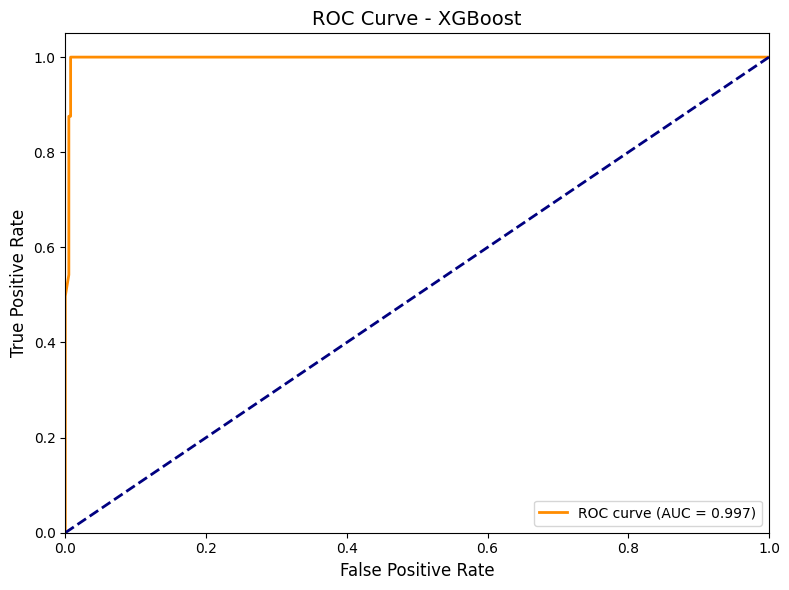

In [73]:
# ROC Curve Visualization for Tuned Model
xgb_pred_proba = gs.predict_proba(X_test_scaled)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)
fpr, tpr, _ = roc_curve(y_test, xgb_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {xgb_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('xgb_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [74]:
# Add Cocnlusion
print("\n" + "="*60)
print("CONCLUSION")
print("="*60)


CONCLUSION


The XGBoost model delivered outstanding performance in predicting traffic situations, achieving 99.50% accuracy, 98.53% precision, and a perfect recall of 100%. Both the baseline and tuned models produced identical results, indicating the model was already well-optimized without requiring further tuning. The low error rate and strong F1-score demonstrate the model's reliability and effectiveness. Future improvements could explore real-time data integration or ensemble blending for even greater robustness.